In [2]:
%load_ext autoreload
%autoreload 2


In [ ]:

from lib.common.mlm_singleton import get_singleton_scorer

mlm = get_singleton_scorer()


In [11]:

from data_config import Exp2Cogs
from paper.exp2_cogs.cogs_utils import get_all_data_clean, read_csv_row_by_row

csv_data_clean = read_csv_row_by_row(Exp2Cogs.cogs_parsed_final)
print(csv_data_clean[0])
all_cogs_clean = get_all_data_clean(csv_data_clean)
# all_clean[0]

in sent Though punctuated by frequent flash-backs to the period before, during and just after the war, temporal progression in the present is clearly marked by the development of two narrative lines which weave their ways in and out of the novel., idx 33 != way
note expected one error message bc one word is 'ways' instead of 'way'


In [12]:
all_cogs_clean[0]

CogsEntry(id=0, cx_type='Let Alone', sent='Most wives are too bloody old, let alone mothers.', tgt_words=[6, 7], tgt_word_offsets=[(31, 34), (35, 40)])

In [14]:
from paper.exp2_cogs.cogs_utils import CogEntryWrapper

all_wrapped = []
for ce in all_cogs_clean:
    all_wrapped.append(CogEntryWrapper(ce))

In [15]:
all_wrapped[0].idiom_token_list


[WrappedIdiomWord(offset=(31, 34), idiom_word_chars='let', tokens=[8], token_words=['let'], is_multiple_tokens=False, tokens_do_not_exact_match=False),
 WrappedIdiomWord(offset=(35, 40), idiom_word_chars='alone', tokens=[9], token_words=['alone'], is_multiple_tokens=False, tokens_do_not_exact_match=False)]

In [16]:
from paper.exp3_magpie.corpus_magpie import EntryForProcessing
from typing import List, Dict
from tqdm import tqdm
from lib.scoring_fns import probability
# from exp6_idioms_magpie.corpus_magpie import EntryForProcessing

"""
Accrue results by cx type and word (word or idx)
 - todo: check multitoken, eg
"""
# adapted from process_sent_exp6
# scores: List[List[float]] = []
def process_sent_exp8(
        cog_entry_wrapped: CogEntryWrapper
) -> List[float]:
    scores: List[float] = []
    cog_entry = cog_entry_wrapped.cog_entry
    entry_for_processing = EntryForProcessing(cog_entry.id, cog_entry.sent)
    for word_to_mask in cog_entry_wrapped.idiom_token_list:
        assert word_to_mask.is_multiple_tokens is False and word_to_mask.tokens_do_not_exact_match is False
        t_idx = word_to_mask.tokens[0]
        inputs_ids = entry_for_processing.get_inputs_with_mask_for_token_at_idx(
            t_idx)
        # get likely fills
        outputs = mlm.get_model_outputs_for_input(inputs_ids)
        logits = outputs.logits

        # predictions is vocab_len [logit, logit, ... logit]
        token_logits = logits[0, t_idx]     # batch, idx, then vocab_len shape

        orig_token_id = entry_for_processing.input_ids[0, t_idx]

        # compute surprisal
        surprisal_score = probability(token_logits, orig_token_id)
        scores.append(surprisal_score.item())
    return scores

def get_all_scores():
    all_scores: List[List[float]] = []
    for cog_wrapped in tqdm(all_wrapped):
        scores = process_sent_exp8(cog_wrapped)
        all_scores.append(scores)
    return all_scores

all_scores = get_all_scores()



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|██████████| 310/310 [00:15<00:00, 20.49it/s]


In [17]:
all_scores[101]

[0.9993739724159241]

In [20]:
from paper.exp2_cogs.cogs_utils import tgt_keys_str_map_no_spaces
# aggregate the data
# hist buckets
from collections import defaultdict
# maps, e.g., "much less" => {0, 1} => List floats for the scores
# so aggreagator[much less][0] -> score list for much
def make_histograms():
    aggregator: Dict[str, List[float]] = defaultdict(list)
    for cog_entry, scores_set in zip(all_cogs_clean, all_scores):
        for i, w in enumerate(cog_entry.tgt_words):
            tgt_word = tgt_keys_str_map_no_spaces[cog_entry.cx_type].split(" ")[i]
            key = f"{cog_entry.cx_type}_{tgt_word}"
            aggregator[key].append(scores_set[i])
    return aggregator

all_aggregated = make_histograms()

In [21]:
len(all_aggregated['Let Alone_let'])

51

/var/folders/58/nkm5hbs97tz3vc0x5l5zl4w40000gn/T/ipykernel_65806/4255280778.py:54: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x=cats_prettied, y=values, ax=ax,inner='quartile', cut=0, edgecolor="black",saturation=0.1, scale="width")


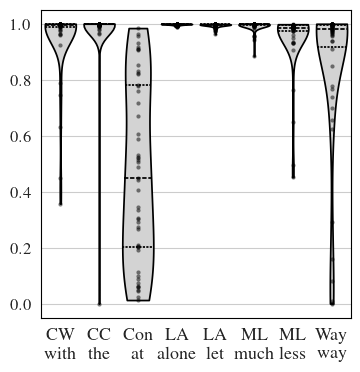

In [22]:
from rozlib.libs.plotting.utils_latex_matplot import config_matplot_for_latex
from lib.utils.utils_misc import save_fig
import matplotlib.pyplot as plt
import seaborn as sns
# from utils.utils_latex_matplot import config_matplot_for_latex, save_fig

# plt.figure(figsize=(6, 6))

config_matplot_for_latex(13)
fig, ax = plt.subplots(figsize=(4,4))
ax.set_ylim(-.05, 1.05)
# ax.set_title("Distribution of contextual probabilities for indicated word")
# ax.set_ylabel("Contextual Probability")
for spine in ax.spines.values():
    spine.set_edgecolor('black')  # Set dark color (or 'white' for light mode)
    # spine.set_linewidth(2)        # Adjust border thickness
# plt.xlabel("Construction & Word")
# categories, values = zip(*[(key, val) for key, vals in all_aggregated.items() for val in vals])

cat_val_tuples = [(key, val) for key, vals in all_aggregated.items() for val in vals]
cat_val_tuples_sorted = sorted(cat_val_tuples, key=lambda x: x[0])
categories, values = zip(*cat_val_tuples_sorted)

cats_sorted = sorted(set(categories))
cat_names_nice = [
    f"cause-\nwith\n'with'",
    f"comp-\ncorr\n'the'",
    f"con-\native\n'at'",
    f"let-\nalone\n'alone'",
    f"let-\nalone\n'let'",
    f"much-\nless\n'much'",
    f"much-\nless\n'less'",
    f"way-cx\n'way'",
]
cat_names_short = [
    f"CW\nwith",
    f"CC\nthe",
    f"Con\nat",
    f"LA\nalone",
    f"LA\nlet",
    f"ML\nmuch",
    f"ML\nless",
    f"Way\nway",
]
def cats_pretty():
    ret = []
    for c in categories:
        idx = cats_sorted.index(c)
        ret.append(cat_names_short[idx])
    return ret
cats_prettied = cats_pretty()

# sns.boxplot(x=cats_prettied, y=values)
# sns.violinplot(x=cats_prettied, y=values, scale="width")
sns.violinplot(x=cats_prettied, y=values, ax=ax,inner='quartile', cut=0, edgecolor="black",saturation=0.1, scale="width")
for violin in ax.collections:
    violin.set_facecolor("lightgray")
sns.stripplot(x=cats_prettied, y=values, ax=ax,
              color="black", alpha=0.5, size=3, jitter=False)  # Adjust size & alpha
save_fig(fig, "cogs_violins.pdf")
# sns.boxplot(x=categories, y=values)

